In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import yaml
from icecream import ic

from bandit_sim.common import Action, Reward
from bandit_sim.configs import AlgorithmConfig, BanditEnvConfig
from bandit_sim.setting import Settings, generate_base_filename

In [2]:
result_dir = "20250817-1731-alignment"
output_dir = os.path.join("../output/", result_dir)

config = {}

with open(os.path.join(output_dir, "simulation_config.yaml"), "r") as config_file:
    raw_dict = yaml.full_load(config_file)  # TODO: Make config loadable.
    for k, v in raw_dict.items():
        if k == "bandit_env_config":
            config_value = BanditEnvConfig.model_validate(v)
        elif k == "algorithm_configs":
            config_value = [AlgorithmConfig.model_validate(alg_dict) for alg_dict in v]
        elif k == "settings":
            config_value = Settings(**v)
        else:
            config_value = v

        config[k] = config_value

settings: Settings = config["settings"]
algorithms: list[AlgorithmConfig] = config["algorithm_configs"]
bandit_env_config = config["bandit_env_config"]
bandit_env_name = config["bandit_env_name"]

# config
T = settings.T
trials = settings.num_trials
K = settings.num_arms
base_seed = settings.base_seed

num_trials = settings.num_trials
trial_id_overrides = settings.trial_id_overrides

if trial_id_overrides is not None and len(trial_id_overrides) > 0:
    trial_ids = trial_id_overrides
    num_trials = len(trial_ids)
else:
    trial_ids = range(num_trials)

num_algs = len(algorithms)
K_env = K // 2

all_regrets = np.zeros((num_trials, num_algs, T), dtype=Reward)
all_actions = np.zeros((num_trials, num_algs, T), dtype=Action)

In [4]:
df = pl.DataFrame()

for i, trial_id in enumerate(trial_ids):
    filename = generate_base_filename(base_seed, trial_id)
    with open(os.path.join(output_dir, f"data_{filename}"), "rb") as f:
        df = df.vstack(pl.read_parquet(f))

ic(df)

ic| df: shape: (80_000, 6)
        ┌──────────┬────────┬────────────┬───────────┬───

────────┬───────┐
        │ reward   ┆ action ┆ info_ratio ┆ algorithm ┆ time_step ┆ trial │
        │ ---      ┆ ---    ┆ ---        ┆ ---       ┆ ---       ┆ ---   │
        │ f64      ┆ u8     ┆ f64        ┆ cat       ┆ i64       ┆ i32   │
        ╞══════════╪════════╪════════════╪═══════════╪═══════════╪═══════╡
        │ 0.176956 ┆ 0      ┆ 1.24894    ┆ IDS       ┆ 0         ┆ 0     │
        │ 0.139276 ┆ 1      ┆ 1.246592   ┆ IDS       ┆ 1         ┆ 0     │
        │ 0.699928 ┆ 2      ┆ 1.243547   ┆ IDS       ┆ 2         ┆ 0     │
        │ 0.946676 ┆ 3      ┆ 1.243041   ┆ IDS       ┆ 3         ┆ 0     │
        │ 0.648299 ┆ 4      ┆ 1.245056   ┆ IDS       ┆ 4         ┆ 0     │
        │ …        ┆ …      ┆ …          ┆ …         ┆ …         ┆ …     │
        │ 0.972636 ┆ 15     ┆ null       ┆ TS-ep1    ┆ 9995      ┆ 3     │
        │ 0.027364 ┆ 15     ┆ null       ┆ TS-ep1    ┆ 9996      ┆ 3     │
        │ 0.972636 ┆ 15     ┆ null       ┆ TS-ep1    ┆ 9997      ┆ 3     │
       

reward,action,info_ratio,algorithm,time_step,trial
f64,u8,f64,cat,i64,i32
0.176956,0,1.24894,"""IDS""",0,0
0.139276,1,1.246592,"""IDS""",1,0
0.699928,2,1.243547,"""IDS""",2,0
0.946676,3,1.243041,"""IDS""",3,0
0.648299,4,1.245056,"""IDS""",4,0
…,…,…,…,…,…
0.972636,15,null,"""TS-ep1""",9995,3
0.027364,15,null,"""TS-ep1""",9996,3
0.972636,15,null,"""TS-ep1""",9997,3


In [ ]:
for i, trial_id in enumerate(trial_ids):
    for alg in algorithms:
        filename = generate_base_filename(base_seed, trial_id, alg.label)
        with open(os.path.join(output_dir, f"regrets_{filename}"), "rb") as f:
            all_regrets[i] = np.load(f)
        with open(os.path.join(output_dir, f"actions_{filename}"), "rb") as f:
            all_actions[i] = np.load(f)

In [3]:
regret_means = np.mean(all_regrets, axis=0)
regret_stds = np.std(all_regrets, axis=0)

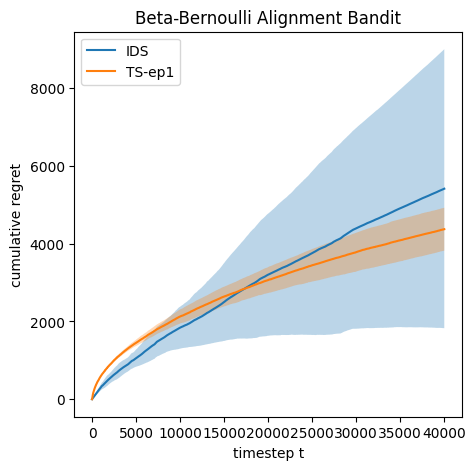

In [4]:
"""
Section below is for plotting
"""
title = bandit_env_name
output = bandit_env_config.label

plt.figure(figsize=(5, 5))

for alg in range(num_algs):
    plt.plot(
        np.arange(T),
        regret_means[alg],
        label=algorithms[alg].label,
    )
    plt.fill_between(
        np.arange(T),
        regret_means[alg] + regret_stds[alg],
        regret_means[alg] - regret_stds[alg],
        alpha=0.3,
    )
# for i in range(num_trials):
#     for alg in range(num_algs):
#         plt.plot(all_regrets[i][alg], color="blue", alpha=0.3)

# for alg in range(num_algs):
#     plt.plot(regret_means[alg], label=algorithms[alg].label)
# plt.xlim(left=0, right=T)
plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

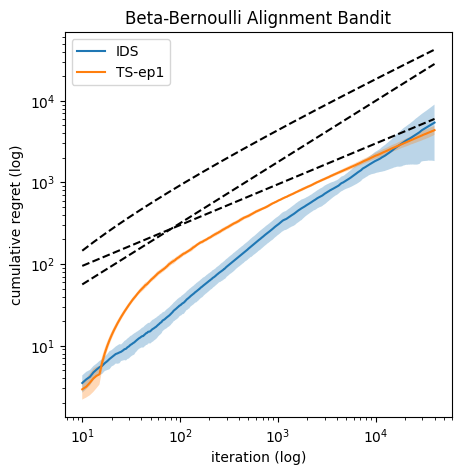

In [38]:
# log log plot
plt.figure(figsize=(5, 5))
for alg in range(num_algs):
    plt.plot(
        np.arange(10, T),
        regret_means[alg][10:],
        label=algorithms[alg].label,
    )
    plt.fill_between(
        np.arange(10, T),
        regret_means[alg][10:] + regret_stds[alg][10:],
        regret_means[alg][10:] - regret_stds[alg][10:],
        alpha=0.3,
    )
# lines for comparison
x = np.arange(10, T)
sqrt_x = 30 * np.sqrt(x)
sqrt_x_log_x = 20 * np.sqrt(x) * np.log(x)
x_3_4 = 10 * x ** (3 / 4)

# plt.plot(x, x, "k--")
plt.plot(x, sqrt_x, "k--")
plt.plot(x, sqrt_x_log_x, "k--")
plt.plot(x, x_3_4, "k--")
# plt.xlim(left=0, right=T)
# plt.ylim(bottom=0, top=120)
plt.title(title)
plt.xlabel("iteration (log)")
plt.ylabel("cumulative regret (log)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [5]:
env_actions = (all_actions < K_env).astype(int)
human_actions = 1 - env_actions

cum_env_actions = np.cumsum(env_actions, axis=2)
cum_human_actions = np.cumsum(human_actions, axis=2)
ic(all_actions.shape)
ic(cum_human_actions[0][0][-1])

ic| all_actions.shape: (8, 2, 40000)
ic| cum_human_actions[0][0][-1]: np.int64(41)


np.int64(41)

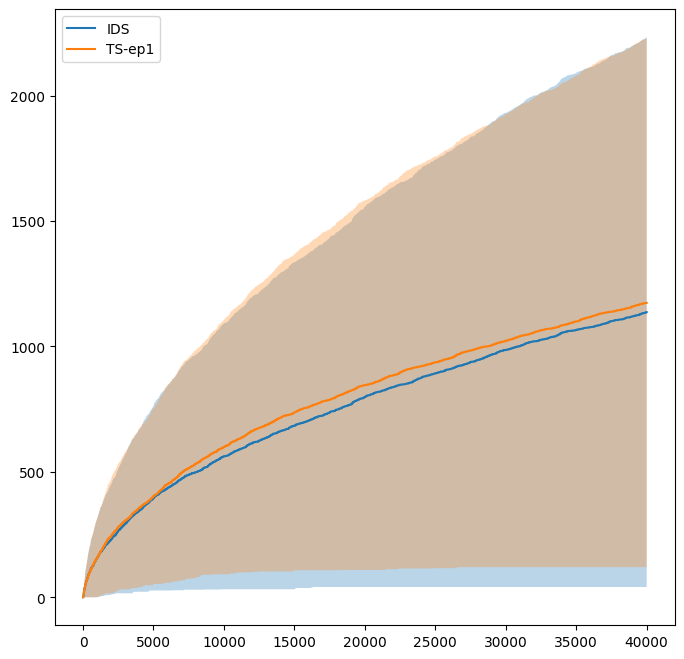

In [9]:
plt.figure(figsize=(8, 8))
for i in range(len(all_actions)):
    # plt.plot(np.arange(T), cum_human_actions[i], color="red", alpha=0.3)
    # plt.plot(np.arange(T), cum_human_actions[i], label=i, alpha=0.8)
    ...
for alg in range(num_algs):
    plt.plot(
        np.arange(T),
        np.mean(cum_human_actions[alg], axis=0),
        label=algorithms[alg].label,
    )
    plt.fill_between(
        np.arange(T),
        np.mean(cum_human_actions[alg], axis=0)
        + np.std(cum_human_actions[alg], axis=0),
        np.mean(cum_human_actions[alg], axis=0)
        - np.std(cum_human_actions[alg], axis=0),
        alpha=0.3,
    )

plt.legend()
plt.show()

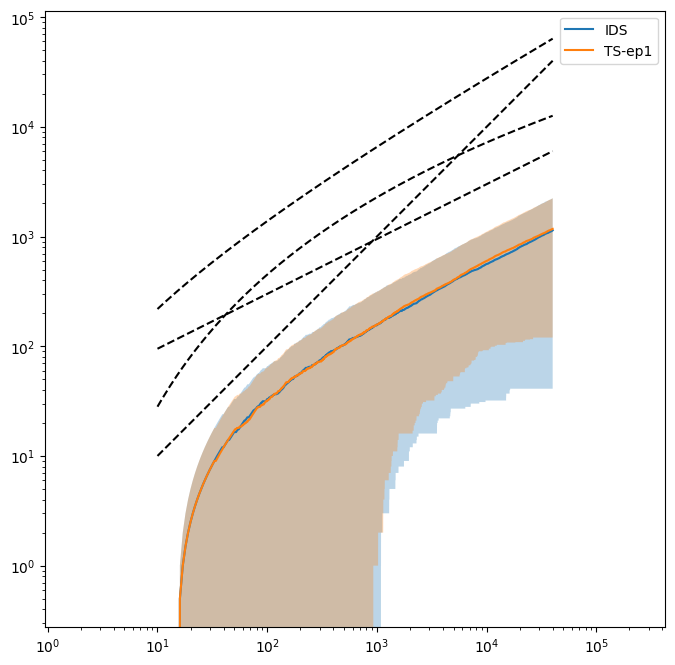

In [6]:
plt.figure(figsize=(8, 8))
for i in range(len(all_actions)):
    # plt.plot(np.arange(T), cum_human_actions[i], color="red", alpha=0.3)
    # plt.plot(np.arange(T), cum_human_actions[i], label=i, alpha=0.8)
    ...
for alg in range(num_algs):
    plt.plot(
        np.arange(10, T, 1),
        np.mean(cum_human_actions[alg], axis=0)[10:],
        label=algorithms[alg].label,
    )
    plt.fill_between(
        np.arange(10, T, 1),
        np.mean(cum_human_actions[alg], axis=0)[10:]
        + np.std(cum_human_actions[alg], axis=0)[10:],
        np.mean(cum_human_actions[alg], axis=0)[10:]
        - np.std(cum_human_actions[alg], axis=0)[10:],
        alpha=0.3,
    )

sqrt_t = np.sqrt(np.arange(10, T, 1))
sqrt_t_log_t = np.sqrt(np.arange(10, T, 1)) * np.log(np.arange(10, T, 1))
log_t = np.log(np.arange(10, T, 1)) * np.log(np.arange(10, T, 1))

plt.plot(np.arange(10, T, 1), np.arange(10, T, 1), color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), 30 * sqrt_t_log_t, color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), log_t**2, color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), 30 * sqrt_t, color="black", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.legend()
plt.show()